In [1]:
import os
#os.chdir('..') # go back to the root directory

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import glob
import random
from braintreebank_config import *
from braintreebank_subject import Subject
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Arial'

In [2]:
from braintreebank_aligned_words import obtain_aligned_words_trigs_df, obtain_estimated_sample_index

subject_id, trial_id = 10, 1

subject = Subject(subject_id, cache=True)
subject.load_neural_data(trial_id)
metadata_file = os.path.join(ROOT_DIR, f'subject_metadata/sub_{subject_id}_trial{trial_id:03}_metadata.json')
with open(metadata_file, 'r') as f:
    meta_dict = json.load(f)
    title = meta_dict['title']
    movie_id = meta_dict['filename']

print("title: ", title, "\n" "movie_id: ", movie_id)
words_df, trigs_df = obtain_aligned_words_trigs_df(subject_id, trial_id)
words_df[['text', 'start', 'end', 'est_idx']]

title:  Spiderman Far From Home 
movie_id:  spider-man-far-from-home
Computing words dataframe for subject 10 trial 1
Kept 11003 words after removing invalid windows


,text,start,end,est_idx
0,Nick,73.796797,74.036797,1910228.0
1,this,74.041000,74.210000,1910728.0
2,was,74.211000,74.335164,1911076.0
3,a,74.352177,74.450000,1911365.0
4,tragedy,74.451000,74.960000,1911568.0
...,...,...,...,...
10998,stop,6927.684345,6927.884345,16756561.0
10999,looking,6927.884345,6928.234345,16756971.0
11000,Oh,6928.891374,6928.991374,16759033.0
11001,my,6928.991374,6929.091374,16759238.0


In [42]:
import numpy as np

SHOW_NEURAL_DATA_BEFORE_SECONDS = 2
SHOW_NEURAL_DATA_AFTER_SECONDS = 0
def render_neural_data(movie_time, electrode_labels, n_rows=None, n_cols=None, save_to=None, close_plot=True, electrode_titles=False):
    show_n_electrodes = len(electrode_labels)
    
    # Default to single column if not specified
    if n_rows is None and n_cols is None:
        n_rows = show_n_electrodes
        n_cols = 1
    elif n_rows is None:
        n_rows = (show_n_electrodes + n_cols - 1) // n_cols
    elif n_cols is None:
        n_cols = (show_n_electrodes + n_rows - 1) // n_rows
        
    # Validate grid dimensions
    assert n_rows * n_cols >= show_n_electrodes, f"Grid size {n_rows}x{n_cols} too small for {show_n_electrodes} electrodes"

    movie_time_from = movie_time - SHOW_NEURAL_DATA_BEFORE_SECONDS
    movie_time_to = movie_time + SHOW_NEURAL_DATA_AFTER_SECONDS

    est_idx = obtain_estimated_sample_index(trigs_df, movie_time)
    window_from = est_idx - SHOW_NEURAL_DATA_BEFORE_SECONDS * SAMPLING_RATE
    window_to = est_idx + SHOW_NEURAL_DATA_AFTER_SECONDS * SAMPLING_RATE

    neural_data = np.zeros((show_n_electrodes, window_to - window_from))
    for i, electrode_label in enumerate(electrode_labels):
        neural_data[i] = subject.get_electrode_data(electrode_label, trial_id, window_from=window_from, window_to=window_to).to('cpu').numpy()

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, .3 + (.6*n_rows if not electrode_titles else .6*n_rows*1.5)))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    time = np.arange(window_from, window_to)

    time_ticks_movie = np.arange(int(np.ceil(movie_time_from)), int(movie_time_to+0.8), 1)
    time_ticks_data = [obtain_estimated_sample_index(trigs_df, t) for t in time_ticks_movie]

    for i in range(show_n_electrodes):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].plot(time, neural_data[i], linewidth=.7, color='black')
        axes[row, col].axvline(x=movie_time, color='red', linestyle='--', alpha=0.5)

        if electrode_titles:
            axes[row, col].set_title(subject.get_electrode_metadata(electrode_labels[i])['DKT'])

        axes[row, col].set_xlim(window_from, window_to)
        axes[row, col].set_ylim(-210, 210)
        axes[row, col].set_yticks([-180, 0, 180])
        axes[row, col].set_yticklabels([])
        
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['bottom'].set_visible(True)
        axes[row, col].spines['left'].set_visible(True)

        axes[row, col].set_xticks([])
        
        # Add labels for leftmost plots
        if col == 0:
            if row == 0:
                axes[row, col].set_ylabel('voltage (mV)')
            elif row==1:
                axes[row, col].set_yticklabels([-180, 0, 180])
            
        # Add time labels for bottom plots
        if row == n_rows-1:
            axes[row, col].set_xticks(time_ticks_data, labels=time_ticks_movie)
            axes[row, col].set_xlabel('time (s)')

    # Hide empty subplots
    for i in range(show_n_electrodes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    if save_to:
        os.makedirs(os.path.dirname(save_to), exist_ok=True)
        plt.savefig(save_to, dpi=300, bbox_inches='tight', pad_inches=0.02)
    if close_plot: plt.close()

In [35]:
# Get all electrode metadata
metadata = subject.get_all_electrode_metadata()

# Get unique DKT values and group electrodes
dkt_groups = {}
for dkt in metadata['DKT'].unique():
    electrodes = metadata[metadata['DKT'] == dkt]['Electrode'].tolist()
    dkt_groups[dkt] = electrodes
    print(f"\n{dkt}:")
    print(", ".join(electrodes))


Right-Hippocampus:
T2bH1, T2bH2, T2bH3, T2bH4, T2bH5

ctx-rh-parahippocampal:
T2bH6

ctx-rh-fusiform:
T2bH7, T2bH8

ctx-rh-inferiortemporal:
T2bH9, T2bH10, T2bH11, T2bH12, T2aA7, T2aA8

ctx-rh-middletemporal:
T2bH13, T2bH14, T2bH15, T2bH16, T2aA9, T2aA10, T2aA11, T2aA12, T2aA13, T2aA14

Right-Amygdala:
T2aA1, T2aA2, T2aA3, T2aA4

Right-Inf-Lat-Vent:
T2aA5, T2aA6

ctx-rh-insula:
T1cIf1, T1bId1, T1aIa1, T1aIa2, T1aIa3, P2aIe1, P2aIe2, P2aIe3, F3cIc1, F3cIc2, F3bIb1, F3bIb2

ctx-rh-transversetemporal:
T1cIf2, T1cIf3, T1cIf4, T1bId4, T1bId5

ctx-rh-superiortemporal:
T1cIf5, T1cIf6, T1cIf7, T1cIf8, T1cIf9, T1cIf10, T1cIf11, T1cIf12, T1bId2, T1bId3, T1bId6, T1bId7, T1bId8, T1bId9, T1bId10, T1aIa5, T1aIa6, T1aIa7, T1aIa8, T1aIa9, T1aIa10

Unknown:
T1aIa4

ctx-rh-isthmuscingulate:
P2cCc1, P2cCc2, P2cCc3, P2cCc4, P2cCc5

ctx-rh-superiorparietal:
P2cCc6, P2cCc7, P2cCc8

ctx-rh-supramarginal:
P2cCc9, P2cCc10, P2cCc11, P2cCc12, P2cCc13, P2cCc14, P2cCc15, P2cCc16, P2bIg1, P2bIg2, P2bIg3, P2bIg4, P

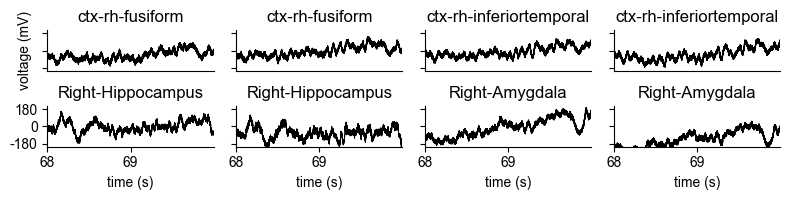

In [43]:
# Select electrodes from key regions
key_electrodes = [
    'T2bH7', 'T2bH8',  # fusiform
    'T2bH9', 'T2bH10',  # inferiortemporal
    'T2bH1', 'T2bH2',  # hippocampus
    'T2aA1', 'T2aA2',  # amygdala
]

# Update your render_neural_data call
render_neural_data(70, key_electrodes, n_rows=2, n_cols=4, close_plot=False, electrode_titles=True)

In [44]:
show_electrode_labels = key_electrodes
movie_from, movie_to = 70, 100

# Generate frames at 25 fps
frame_rate = 25
frames = np.arange(movie_from, movie_to, 1/frame_rate)
for frame_i, frame in enumerate(frames):
    if frame_i % frame_rate == 0: print(frame)
    render_neural_data(frame, show_electrode_labels, save_to=f'neural_data_frames/{movie_id}-{subject_id}-{frame:.3f}.jpg',
                       n_rows=2, n_cols=4, close_plot=True, electrode_titles=True)

70.0
71.00000000000016
72.00000000000031
73.00000000000047
74.00000000000063
75.00000000000078
76.00000000000094
77.0000000000011
78.00000000000125
79.0000000000014
80.00000000000156
81.00000000000172
82.00000000000188
83.00000000000203
84.00000000000219
85.00000000000234
86.0000000000025
87.00000000000266
88.00000000000281
89.00000000000297
90.00000000000313
91.00000000000328
92.00000000000344
93.0000000000036
94.00000000000375
95.00000000000391
96.00000000000406
97.00000000000422
98.00000000000438
99.00000000000453


In [53]:
import subprocess
import glob
import os

fps = 25
frame_pattern = f'neural_data_frames/{movie_id}-{subject_id}*.jpg'
output_file = f'neural_data_{movie_id}_{subject_id}.mp4'

# Create a text file listing all frames
frames = sorted(glob.glob(frame_pattern))
if len(frames) > 0:
    # Create a temporary file listing all frames
    with open('frames.txt', 'w') as f:
        for frame in frames:
            f.write(f"file '{frame}'\n")
    
    # Use the concat demuxer instead of glob
    subprocess.run([
        '.\\ffmpeg.exe', '-y',
        '-f', 'concat',
        '-safe', '0',
        '-r', str(fps),
        '-i', 'frames.txt',
        '-vf', 'scale=2322:546',  # Force height to nearest even number
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        output_file
    ], check=True, stderr=subprocess.PIPE, text=True)
    
    # Clean up the temporary file
    os.remove('frames.txt')
else:
    print(f"No frames found matching pattern: {frame_pattern}")

In [51]:
print(' '.join([
    '.\\ffmpeg.exe', '-y',
    '-f', 'concat', 
    '-safe', '0',
    '-r', str(fps),
    '-i', 'frames.txt',
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_file
]))

.\ffmpeg.exe -y -f concat -safe 0 -r 25 -i frames.txt -c:v libx264 -pix_fmt yuv420p neural_data_spider-man-far-from-home_10.mp4
